In [193]:
import datetime
from pytz import timezone

# from collections import OrderedDict
from copy import deepcopy


import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

LAMBDA_PEN = 1000
L_BOUND = -10
U_BOUND = 10
N_POINTS = 512

NUM_EPOCHS = 5000

M_POINTS = 10
ALPHA = 2

SELECTION_RATE = 0.01

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [119]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [120]:
def epsilon_Loss(v_x, model_u, upper_bound, discrete_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime_x = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        t = torch.abs(torch.square(u_prime_x)) + v_xi*torch.square(u_xi)

        total += t
    return h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         upper_bound, discrete_points):
    """
    
    """
    eps_sum = 0
    pen = 0

    h = (2*upper_bound)/(len(discrete_points)-1)
#     print("h = "+ str(h))
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)

        u_prime = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        u_xi = model_u(x_i)
        u_xi_square = torch.square(u_xi)

        t = torch.abs(torch.square(u_prime)) + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return (epsilon_fn, epsilon_fn + penalty)

In [ ]:
# ITERATIVE
tensor_points = []
for i in DISCRETE_POINTS:
    x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
    tensor_points.append(x_i)
start1 = time.time()
epsilon_Loss_penalty(p_fn, model_32, LAMBDA_PEN,
                     U_BOUND, np.random.choice(DISCRETE_POINTS, size=32))

# for i in tensor_points:
#     u_prime = model_64.u_prime(x_i)

end1 = time.time()
time1 = end1-start1
print("Time " + str(time1))

h = 0.6451612903225806
Time 0.018925189971923828


In [270]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super(Nonlinear, self).__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1] - discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]
    


In [ ]:
# TRANING MODEL
def minibatch_train_with_penalty(model, 
                               num_epochs, 
                               v_x, 
                               optimizer, 
                               lambda_pen,
                               discrete_points,
                               batch_size=32):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []

    m = len(discrete_points)
    num_batches = int(m/batch_size)
#         print("Number of batches " + str(num_batches))

    for epoch in range(num_epochs):
        perm = torch.randperm(m)
        avg_loss_pen = 0
        avg_loss = 0

#                 start1 = time.time()
        for i in range(0, m, batch_size):
#                 print("i = " + str(i))
            optimizer.zero_grad()

            indices = perm[i: i+batch_size]

            loss_values = epsilon_Loss_penalty(v_x, model, lambda_pen,
                                            U_BOUND, 
                                            discrete_points[indices])

            loss = loss_values[0]
            loss_pen = loss_values[1]

            avg_loss_pen += loss_pen.item()
            avg_loss += loss.item()

            loss_pen.backward()
            optimizer.step()

        avg_loss_pen = avg_loss_pen/num_batches
        avg_loss = avg_loss/num_batches

        y_loss_pen.append(avg_loss_pen)
        y_loss.append(avg_loss)
        x_epochs.append(epoch)

        if epoch % 100 == 0 or epoch < 30:
            print('epoch {}, loss with penalty {}'.format(epoch, avg_loss_pen))

#                 if epoch == 0:
#                     end1 = time.time()
#                     time1 = end1-start1
#                     print("One epoch takes " + str(time1))

    print('Please normalize after training')
    return (x_epochs, y_loss_pen, y_loss)

def batch_train_with_penalty(model, 
                         num_epochs, 
                         v_x, 
                         optimizer, 
                         lambda_pen, 
                         discrete_points):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []

    #Early stopping criteria:
    last_min_loss = 0
    patience = 4
    min_delta = 1e-3
    stop_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss_values = epsilon_Loss_penalty(v_x, model, lambda_pen,
                                    U_BOUND, discrete_points)

        loss = loss_values[0]
        loss_pen = loss_values[1]

        y_loss_pen.append(loss_pen.detach().numpy().item())
        y_loss.append(loss.detach().numpy().item())
        x_epochs.append(epoch)

#             if epoch == 0:
#                 last_min_loss = loss_pen
#             else:
#             #Early stopping
#                 if abs(loss_pen-last_min_loss) <= min_delta:
#                     stop_counter += 1
#                     print("Stop counter + 1, current stop counter = " + str(stop_counter))
#                     if loss_pen < last_min_loss:
#                         last_min_loss = loss_pen
#                         best_model = copy.deepcopy(self.state_dict())

#                     if stop_counter >= patience:
#                         print("Early stopping. Training is complete")
#                         print('Please normalize after training')
#                         return (x_epochs, y_loss_pen, y_loss)
#                 else:
#                     stop_counter = 0


#             if epoch % 100 == 0 or epoch < 30:
        print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
        loss_pen.backward()
        optimizer.step()

    print('Please normalize after training')
    return (x_epochs, y_loss_pen, y_loss)

In [ ]:
# For potential function
ti_list = np.random.normal(loc=0, scale=1.0, size= M_POINTS)
ci_list = [(U_BOUND/(i * math.pi))**ALPHA for i in range(1, M_POINTS+1)]


def potential_func_iterative(x, t_list, c_list, M_points=M_POINTS, L_endpoint=U_BOUND, c_0=50):
    f_value = 0
    summation = 0
    #Iterative method:

    for i in range(1, M_points+1):
        cos_val = np.cos((i * math.pi * x)/L_endpoint)
        summation += t_list[i-1] * c_list[i-1] * cos_val

    f_value += summation
    f_value += c_0

    return f_value


def potential_func_linalg(x, M_points=20, L_endpoint=U_BOUND, alpha=3, c_0=100):    
    # Linear Algebra method:
    t_i = np.random.normal(0, 1, size=N_points)
    
    iter1 = ((math.pi/(i*L_endpoint))**alpha for i in range(1, M_points+1))
    c_i = np.fromiter(iter1, float)
    a = np.multiply(t_i, c_i)

    iter2 = (i for i in range(1, M_points+1))
    v = np.fromiter(iter2, float)
    s = (L_endpoint*x/math.pi)*v
    cos_s = np.cos(s)
    
    res_vector = np.multiply(a, cos_s)
    return np.sum(res_vector) + c_0

In [128]:
class X_Square:
    def __init__(self, const):
        self.const = const
        
    def forward(self, x):
        return x**2 + self.const + 13*math.sin(x)
    
class Potential_Function:
    def __init__(self, c_0=0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA, 
                 rescale=1):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        self.rescale = 1
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = [(self.L_endpoint/(i * math.pi))**self.alpha 
                        for i in range(1, self.M_points+1)]
        
    def forward(self, x):
        f_value = 0
        summation = 0
        
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0
        return self.rescale * f_value
    
    def set_c0_value(self, val):
        self.c_0 = val
        return
    
    def set_rescale_factor(self, val):
        self.rescale = val
        return 
    
    def plot_function(self, discrete_points):
        y_values = [self.forward(i) for i in discrete_points]
        plt.plot(discrete_points, y_values)
    
    def update_potential_fn(self, discrete_points):
        # (1) Check lowest value to set appropriate c_0 value:
        y_values = [self.forward(i) for i in discrete_points]
        min_val = min(y_values)
        print("Original min val = " + str(min_val))
        # plt.plot(DISCRETE_POINTS, y_values)

        # (1) Set c_0 value s.t. every value in y_values is > 0: 
        if min_val < 0:
            c_0 = math.ceil(abs(min_val))
            self.set_c0_value(c_0)
            new_y = [self.forward(i) for i in discrete_points]
            print("Min val with c_0 updated = " + str(min(new_y)))
        # plt.plot(DISCRETE_POINTS, new_y)

        # (2) Rescale potential function s.t. every value lies between 0 and 5:
        max_v = max(new_y)
#         min_v = min(new_y)
#         print(max_v, min_v)
#         max_min = max_v-min_v

#         rescaled_y = [(i-min_v)/(max_min) for i in new_y]
#         plt.plot(DISCRETE_POINTS, rescaled_y)

        c = 5/max_v
        self.set_rescale_factor(c)
        return

In [124]:
def model_on_interval(nn_model, discrete_points):
    x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in discrete_points]

    model_output = []
    for i in x_vals:
        model_output.append(nn_model(i).detach().numpy().item())
    return model_output

In [273]:
learningRate = 0.01

#INIT MODEL
batch_model = Nonlinear(40)
model_32 = Nonlinear(20)
model_64 = Nonlinear(20)
model_128 = Nonlinear(20)
if torch.cuda.is_available():
    model_32.cuda()
    model_64.cuda()

# INIT OPTIMIZER CLASS
# SGD:
# sgd_optimizer = torch.optim.SGD(model_32.parameters(), 
#                                 lr=learningRate, 
#                                 momentum=0.9)

# Adam:
adam_optimizer = torch.optim.Adam(batch_model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_optimizer_2 = torch.optim.Adam(model_64.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_optimizer_3 = torch.optim.Adam(model_128.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)


In [272]:
del adam_optimizer
del adam_optimizer_2
del adam_optimizer_3

del model_32
del model_64
del model_128
del batch_model

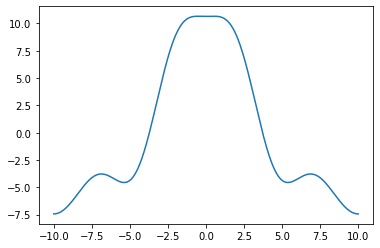

In [206]:
# Init. potential function instance
p_fn = Potential_Function()
p_fn.plot_function(DISCRETE_POINTS)

Original min val = -7.432248081807909
Min val with c_0 updated = 0.5677519181920907


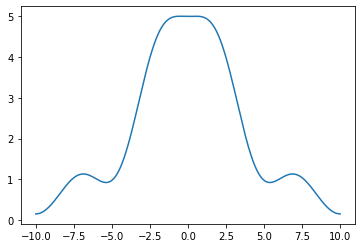

In [207]:
p_fn.update_potential_fn(DISCRETE_POINTS)
p_fn.plot_function(DISCRETE_POINTS)

In [275]:
batch_res = None

In [276]:
model_res_32 = None
model_res_64 = None
model_res_128 = None

In [277]:
### TRAIN MODEL HERE ###
def run_batch_training(nn_model, v_x, optimizer):
    
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print("Start time is " + str(now))
    start = time.time()
    
    model_res = nn_model.batch_train_with_penalty(NUM_EPOCHS, 
                                                v_x, 
                                                optimizer, 
                                                LAMBDA_PEN, 
                                                DISCRETE_POINTS)
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))
    return model_res

def run_minibatch_training(nn_model, v_x, optimizer, b_size):
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print(("Start time for batch_size = {a} is " + str(now)).format(a=b_size))
    start = time.time()
    
    model_res = nn_model.minibatch_train_with_penalty(NUM_EPOCHS, 
                                                      v_x, 
                                                      optimizer, 
                                                      LAMBDA_PEN, 
                                                      DISCRETE_POINTS,
                                                      batch_size=b_size)
    
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))
    return model_res

In [ ]:
test_model = Nonlinear(20)
adam_opt = torch.optim.Adam(test_model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)
test_res = run_minibatch_training(test_model, e_fn, adam_opt, b_size=64)

In [ ]:
test_model.normalize_model(DISCRETE_POINTS)

In [ ]:
batch_res = run_batch_training(batch_model, p_fn, adam_optimizer)

In [87]:
min_val = min(batch_res[2])

for i in range(len(batch_res[2])):
    if abs(batch_res[2][i]-min_val) > 1e-2:
        print(i)

In [ ]:
batch_model.normalize_model(DISCRETE_POINTS)

In [55]:
max(batch_res[2][1200:3000])-min(batch_res[2][1200:3000])

0.39970827102661133

<Figure size 432x288 with 0 Axes>

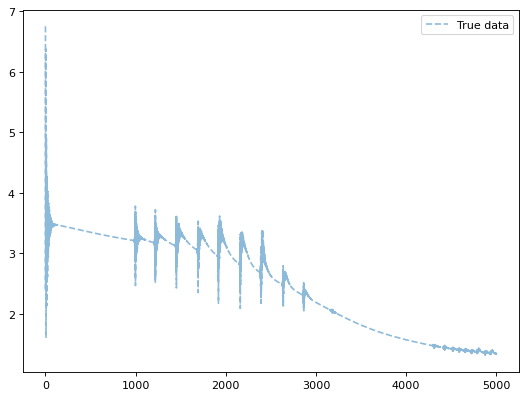

In [280]:
plot_figure(batch_res[0], (batch_res[2]))

In [203]:
sum(batch_res[2][2000:2700])/len(batch_res[2][2000:2700])

0.4980825331381389

<Figure size 432x288 with 0 Axes>

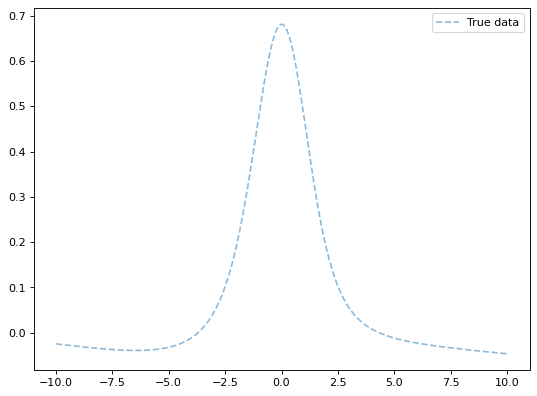

In [281]:
x_values = np.linspace(L_BOUND, U_BOUND, N_POINTS)
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in np.linspace(L_BOUND, U_BOUND, N_POINTS)]

model_output = model_on_interval(batch_model, DISCRETE_POINTS)

plot_figure(x_values, model_output)
# plot_figure(x_values, model_output)

## The Finite Difference Method ##

In [173]:
def fd_method_2(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)
    H = np.zeros((N_points-2,N_points-2))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points-2,N_points-2))
    
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
                
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])
                
    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [174]:
def finite_diff_method(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [204]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model=None):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * -ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    if nn_model != None:
        model_output = model_on_interval(nn_model, DISCRETE_POINTS)
        plt.plot(discrete_points, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

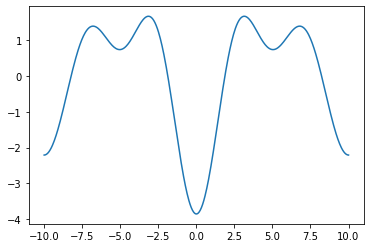

In [266]:
# Init. potential function instance
p_fn = Potential_Function()
p_fn.plot_function(DISCRETE_POINTS)

Original min val = -3.8592441284024055
Min val with c_0 updated = 0.1407558715975945


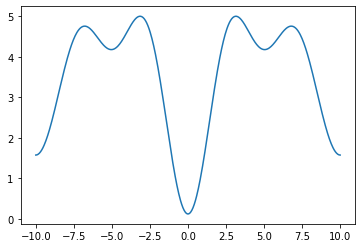

In [267]:
p_fn.update_potential_fn(DISCRETE_POINTS)
p_fn.plot_function(DISCRETE_POINTS)

In [268]:
fd_res = finite_diff_method(L_BOUND, U_BOUND, N_POINTS, p_fn)
fd_res2 = fd_method_2(L_BOUND, U_BOUND, N_POINTS, p_fn)
print(fd_res[0])
print(fd_res2[0])

[1.22746061]
[1.22746061]


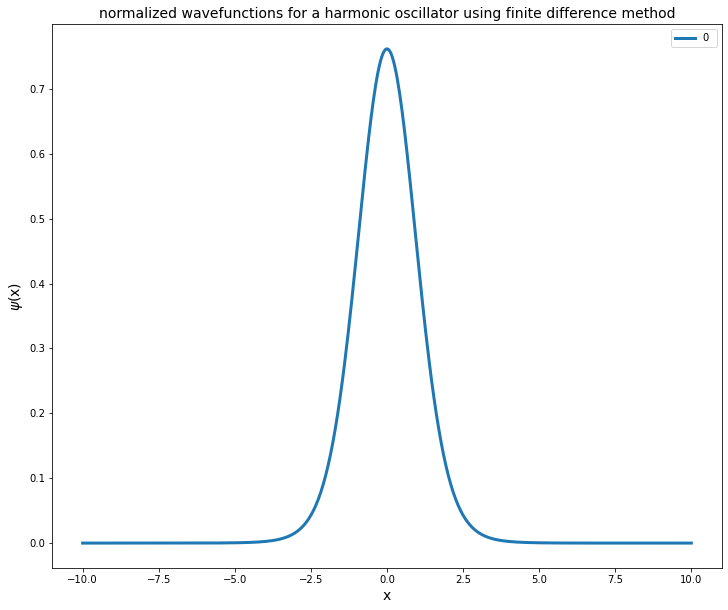

In [269]:
plot_finite_diff_sol(fd_res[0], fd_res[1], DISCRETE_POINTS)

In [156]:
p_fn.rescale * 2.565580129623413

1.352220980710314

In [283]:
loss_val = epsilon_Loss_penalty(p_fn, batch_model, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)[0]
print("The FD method eigenvalue: " + str(fd_res[0][0]))
print("The NN method loss value: " + str(loss_val.item()))

The FD method eigenvalue: 1.2274606132546275
The NN method loss value: 1.3539081811904907


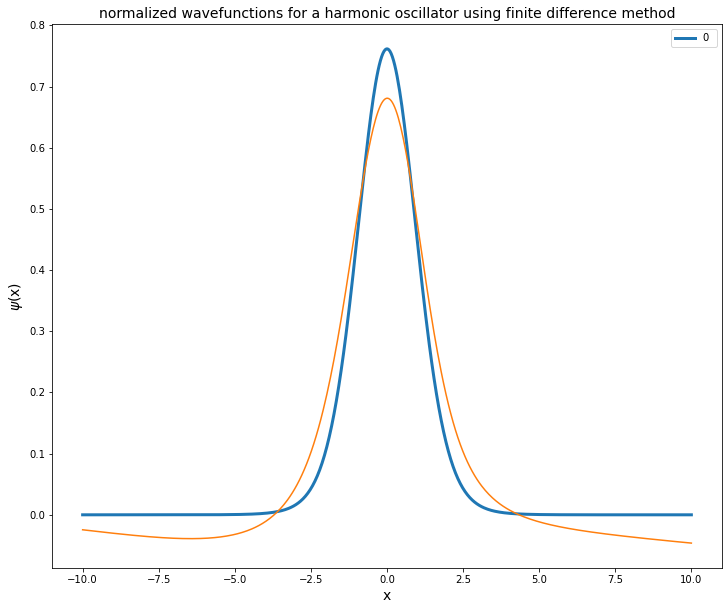

In [282]:
plot_finite_diff_sol(fd_res[0], fd_res[1], DISCRETE_POINTS, batch_model)